In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import csv
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import os
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.preprocessing import MinMaxScaler
os.environ['CUDA_VISIBLE_DEVICES']=''
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [2]:

def get_load_data(date):
    url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
    print('Scraping ' + date, end=' ')
    resp = requests.get(url + date) # send a get request to the url, get response
    soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
    table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
    trs = table.findAll('tr') # extract all rows of the table

    if len(trs[1:])==288: # no need to create csv file, if there's no data
        with open('monthdata.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
            writer = csv.writer(f)
            for tr in trs[1:]:
                time, delhi = tr.findChildren('font')[:2]
                writer.writerow([date + ' ' + time.text, delhi.text])
    if len(trs[1:]) != 288:
        print('Some of the load values are missing..')
    else:
        print('Done')

In [3]:

for i in range(31, 0, -1):
    yesterday = datetime.today() - timedelta(i)
    yesterday = yesterday.strftime("%d/%m/%Y")
    get_load_data(yesterday)   

Scraping 15/04/2021 Done
Scraping 16/04/2021 Done
Scraping 17/04/2021 Done
Scraping 18/04/2021 Done
Scraping 19/04/2021 Done
Scraping 20/04/2021 Done
Scraping 21/04/2021 Done
Scraping 22/04/2021 Done
Scraping 23/04/2021 Done
Scraping 24/04/2021 Done
Scraping 25/04/2021 Some of the load values are missing..
Scraping 26/04/2021 Done
Scraping 27/04/2021 Done
Scraping 28/04/2021 Done
Scraping 29/04/2021 Done
Scraping 30/04/2021 Done
Scraping 01/05/2021 Done
Scraping 02/05/2021 Done
Scraping 03/05/2021 Done
Scraping 04/05/2021 Done
Scraping 05/05/2021 Done
Scraping 06/05/2021 Done
Scraping 07/05/2021 Done
Scraping 08/05/2021 Done
Scraping 09/05/2021 Done
Scraping 10/05/2021 Done
Scraping 11/05/2021 Done
Scraping 12/05/2021 Done
Scraping 13/05/2021 Done
Scraping 14/05/2021 Done
Scraping 15/05/2021 Done


In [4]:
data = pd.read_csv('monthdata.csv', header=None, names=['datetime', 'load'], index_col=[0], parse_dates=[0], infer_datetime_format=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8640 entries, 2021-04-15 00:00:00 to 2021-05-15 23:55:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    8640 non-null   float64
dtypes: float64(1)
memory usage: 135.0 KB


In [78]:
for i in range(31, 0, -1):
    yesterday = datetime.today() - timedelta(i)
    yesterday = yesterday.strftime('%Y-%m-%d')
    try:
        print(data[yesterday].shape[0])
    except:
        print(yesterday, 'not found')
     

288
288
288
288
288
288
288
288
288
288
288
0
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288


In [79]:
data.shape

(8640, 1)

In [80]:
data.shape[0] / 288 

30.0

In [82]:
data.head()

,load
datetime,
2021-04-14 00:00:00,3611.79
2021-04-14 00:05:00,3574.68
2021-04-14 00:10:00,3563.17
2021-04-14 00:15:00,3537.44
2021-04-14 00:20:00,3529.50


In [83]:
data.head(1)

,load
datetime,
2021-04-14,3611.79


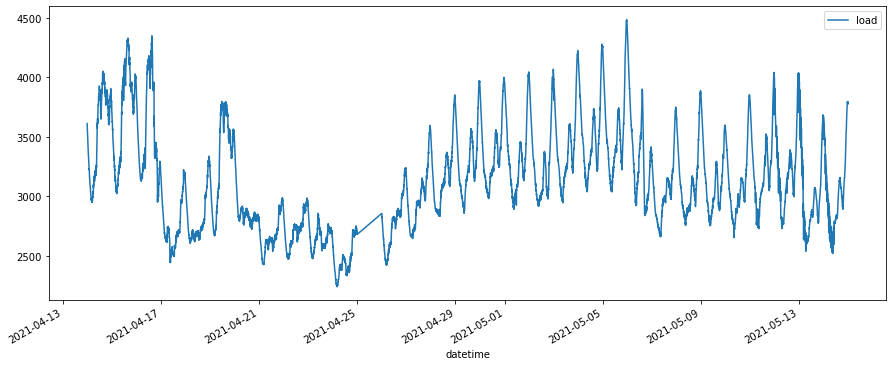

In [84]:
data.plot()
plt.rcParams['figure.figsize'] = (20, 6)
plt.show()

In [85]:
set(data.index.date)

{datetime.date(2021, 4, 14),
 datetime.date(2021, 4, 15),
 datetime.date(2021, 4, 16),
 datetime.date(2021, 4, 17),
 datetime.date(2021, 4, 18),
 datetime.date(2021, 4, 19),
 datetime.date(2021, 4, 20),
 datetime.date(2021, 4, 21),
 datetime.date(2021, 4, 22),
 datetime.date(2021, 4, 23),
 datetime.date(2021, 4, 24),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 27),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 4, 29),
 datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 1),
 datetime.date(2021, 5, 2),
 datetime.date(2021, 5, 3),
 datetime.date(2021, 5, 4),
 datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6),
 datetime.date(2021, 5, 7),
 datetime.date(2021, 5, 8),
 datetime.date(2021, 5, 9),
 datetime.date(2021, 5, 10),
 datetime.date(2021, 5, 11),
 datetime.date(2021, 5, 12),
 datetime.date(2021, 5, 13),
 datetime.date(2021, 5, 14)}

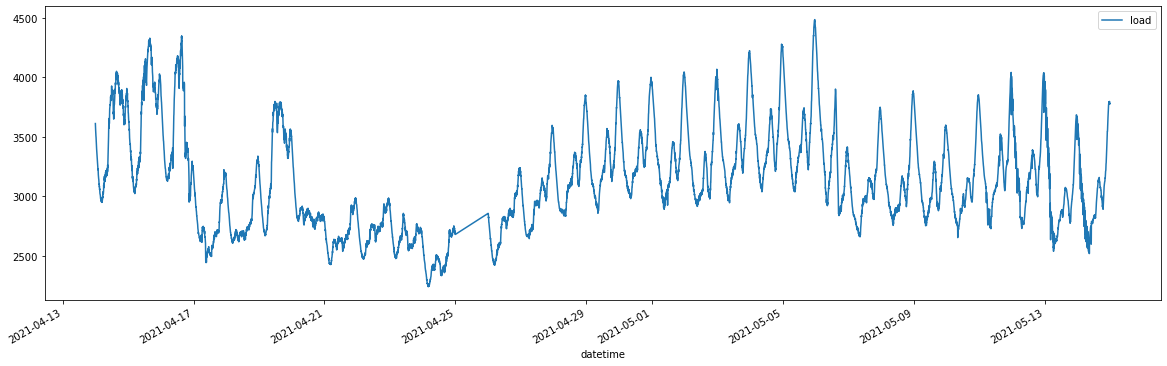

In [88]:
data[:'2021-05-20'].plot()
plt.rcParams['figure.figsize'] = (15, 6)
plt.show()

In [90]:
data.shape

(8640, 1)

In [91]:
# number of unique dates in the data
len(set(data.index.date))

30

In [92]:
data.tail()

,load
datetime,
2021-05-14 23:35:00,3797.48
2021-05-14 23:40:00,3794.17
2021-05-14 23:45:00,3789.13
2021-05-14 23:50:00,3775.20
2021-05-14 23:55:00,3778.78


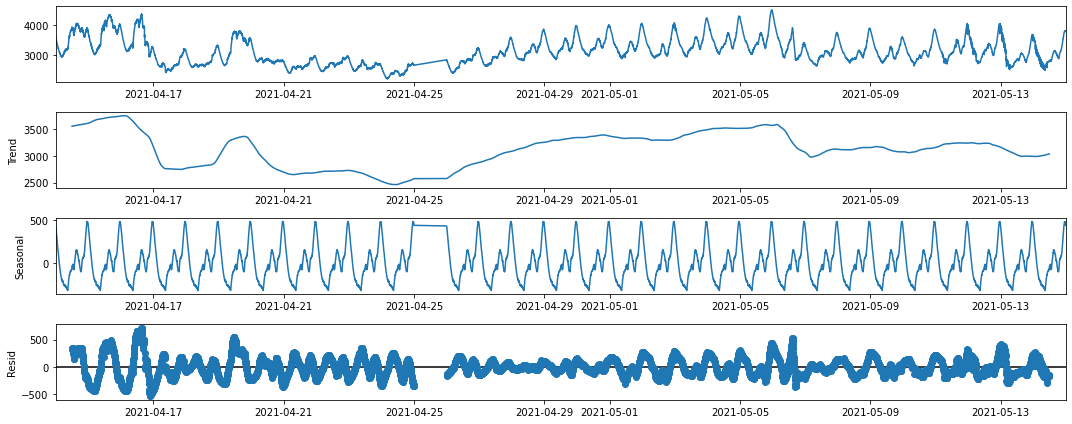

In [94]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 288 #daily freq
from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(data[:'24/10/2018'], freq=decompfreq, model='aditive')
result = seasonal_decompose(data, period=decompfreq, model='aditive')

result.plot()
plt.show()


### Making the data stationary


## Detrending

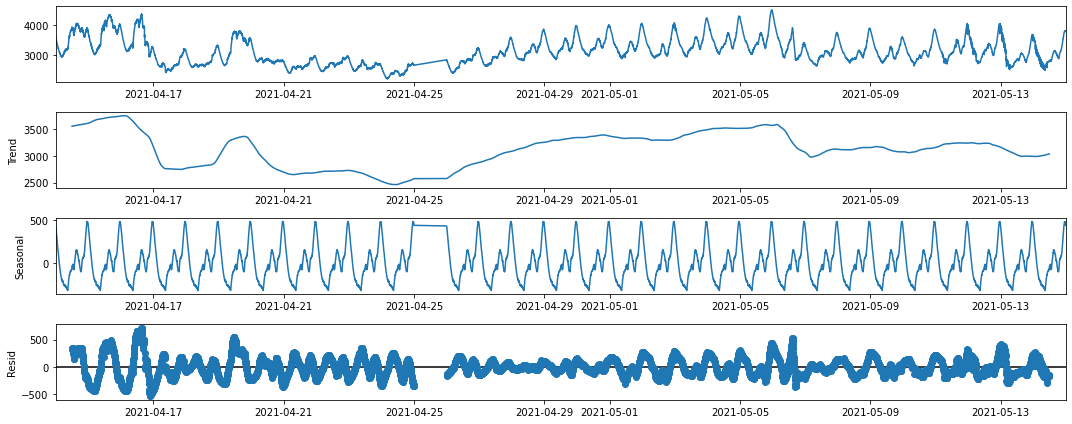

In [95]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 288 #daily freq
result = seasonal_decompose(data, period=decompfreq, model='aditive')
result.plot()
plt.show()

In [96]:
dt_data = data.diff(1).dropna()  # detrended data

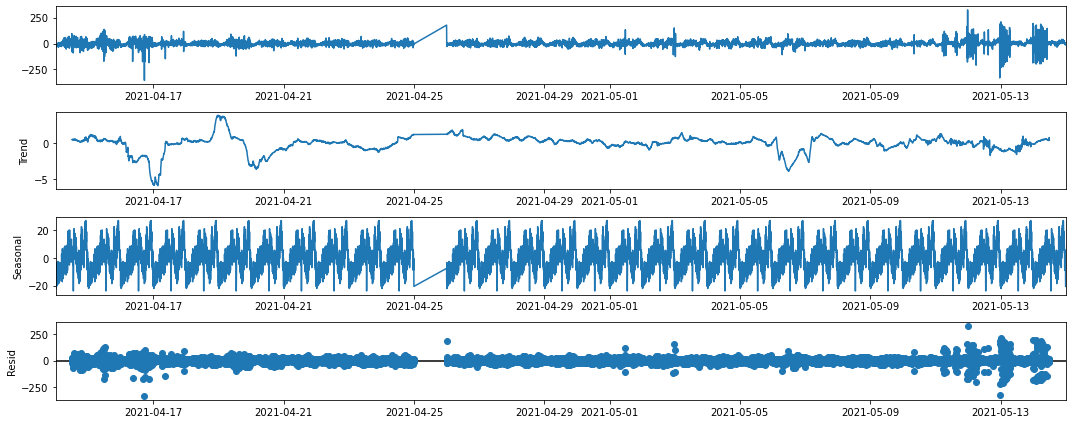

In [97]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 288 #daily freq
result = seasonal_decompose(dt_data, period=decompfreq, model='aditive')
result.plot()
plt.show()

### Removing seasonality

<AxesSubplot:xlabel='datetime'>

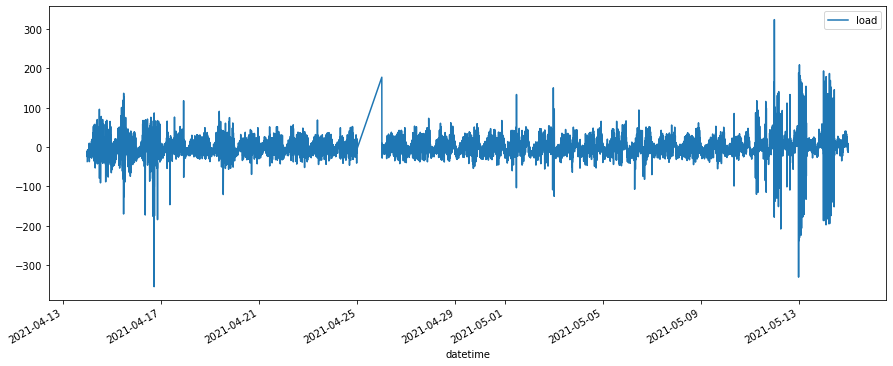

In [98]:
dt_data.plot()

In [103]:
lag_pacf = pacf(dt_data['load'].values, nlags = 2000)

C:\Users\ayush\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


In [104]:
lag_acf = acf(dt_data['load'].values, nlags = 2000)

C:\Users\ayush\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [105]:
np.argsort(lag_pacf)

array([1615, 1591, 1614, ...,    0, 1616, 1590], dtype=int64)

In [106]:
np.argsort(lag_acf)

array([  1,  44, 355, ..., 291,   5,   0], dtype=int64)

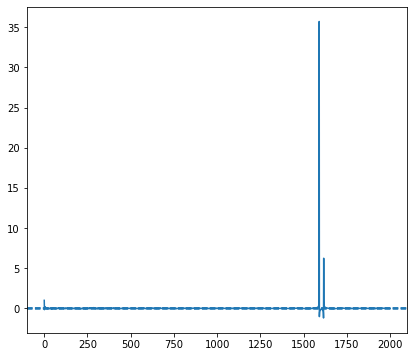

In [107]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(dt_data['load'])), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(dt_data['load'])), linestyle='--')

# critical value determination: https://stats.stackexchange.com/a/185553/181916

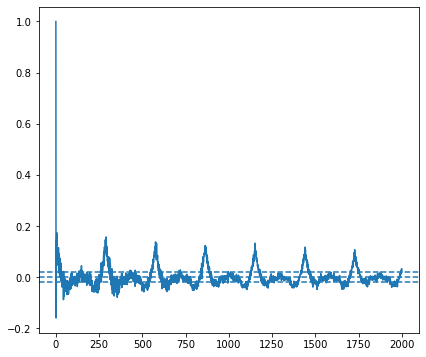

In [108]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(dt_data['load'])), linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(dt_data['load'])), linestyle='--')

# critical value determination: https://stats.stackexchange.com/a/185553/181916

In [109]:
ds_dt_data = dt_data.diff(288).dropna()  # deseasonalized + detrended data

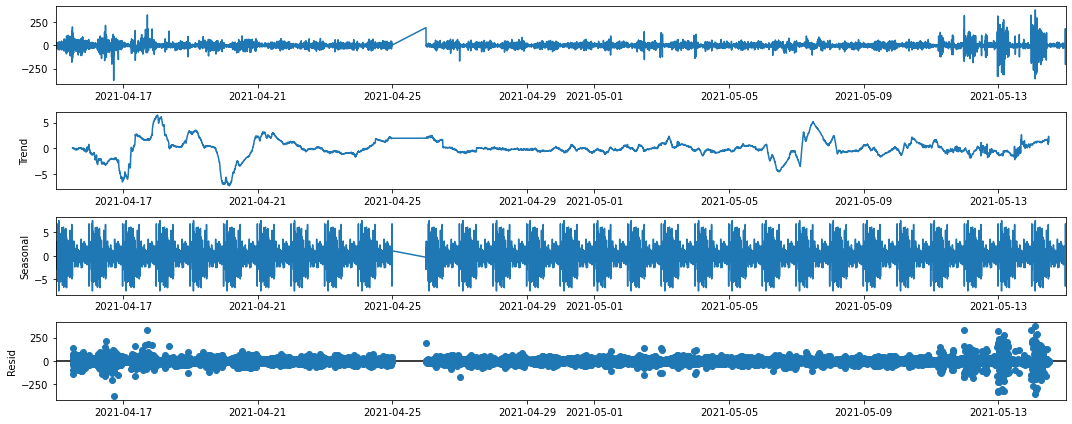

In [110]:
decompfreq = 288 #daily freq
result = seasonal_decompose(ds_dt_data, period=decompfreq, model='aditive')
result.plot()
plt.show()

<AxesSubplot:xlabel='datetime'>

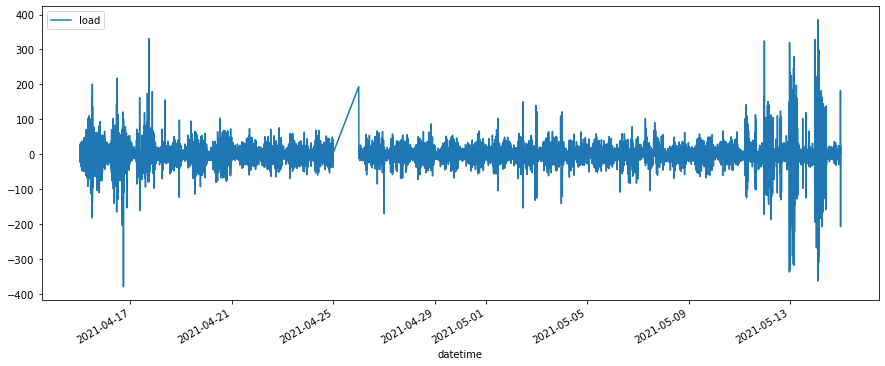

In [111]:
ds_dt_data.plot()

## Rescale the data

In [112]:
ds_dt_data.shape

(8351, 1)

In [113]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(ds_dt_data['load'].values.reshape(-1, 1))

In [114]:
ds_dt_data['load1'] = ds_dt_data.shift(-1)['load']
ds_dt_data['load2'] = ds_dt_data.shift(-2)['load']
ds_dt_data['load3'] = ds_dt_data.shift(-3)['load']
ds_dt_data = ds_dt_data.dropna()

In [115]:
ds_dt_data = scaler.transform(ds_dt_data)  # don't use .values

In [116]:
split_idx = int(0.9 * len(ds_dt_data))
train, val = ds_dt_data[:split_idx], ds_dt_data[split_idx:]

In [117]:
train.shape, val.shape

((7513, 4), (835, 4))

In [118]:
X, y = train[:, 0], train[:, 1:]
X_val, y_val = val[:, 0], val[:, 1:]

In [119]:
y_val

array([[-0.0260906 ,  0.26532855, -0.27990474],
       [ 0.26532855, -0.27990474, -0.0132154 ],
       [-0.27990474, -0.0132154 , -0.10349881],
       ...,
       [ 0.03169079, -0.00416089,  0.46819145],
       [-0.00416089,  0.46819145, -0.55083349],
       [ 0.46819145, -0.55083349,  0.0490409 ]])

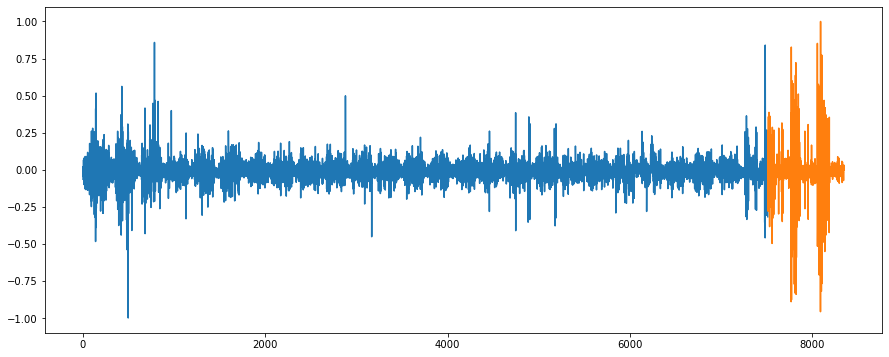

In [120]:
plt.plot(range(len(X)), X)
plt.plot(range(len(X), len(X_val) + len(X)), X_val);

In [123]:
# to get the original series back
#inverted_X = scaler.inverse_transform(scaled_X)

## LSTM model development

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

In [124]:
X.shape, y.shape

((7513,), (7513, 3))

In [125]:
X = X.reshape(X.shape[0], 1, 1)

In [126]:

model = Sequential()
model.add(LSTM(1, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [127]:
# fit network
for i in range(10):
    model.fit(X, y, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()


In [128]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [129]:
forecasts = make_forecasts(model, 1, train, val, 1, 3)

In [130]:
forecasts

[[-0.024260618, -0.0075801704, -0.0075647966],
 [-0.011733591, -0.010562453, -0.010260548],
 [-0.076867074, 0.004943737, 0.0037558395],
 [0.041146524, -0.023151511, -0.021640074],
 [-0.00075042807, -0.013177192, -0.012624068],
 [0.012393724, -0.016306393, -0.0154526215],
 [-0.089321524, 0.007908741, 0.0064359717],
 [0.0374744, -0.022277296, -0.020849854],
 [-0.007993845, -0.011452767, -0.011065322],
 [-0.015950438, -0.0095585575, -0.009353105],
 [0.030356873, -0.020582842, -0.019318197],
 [-0.006412563, -0.01182922, -0.011405606],
 [-0.0988404, 0.010174882, 0.008484387],
 [-0.028988846, -0.006454531, -0.0065473067],
 [0.0479949, -0.02478189, -0.02311381],
 [-0.0019071512, -0.012901813, -0.012375147],
 [-0.019403009, -0.008736611, -0.008610129],
 [-0.012536985, -0.010371191, -0.010087661],
 [-0.011311389, -0.010662966, -0.010351404],
 [0.081841365, -0.032839645, -0.030397393],
 [0.0015341192, -0.013721069, -0.013115691],
 [-0.0028807726, -0.012670025, -0.012165628],
 [-0.09348701, 0.008

In [131]:
# y_val_hat = [x[0] for x in forecasts]

In [132]:
y_val_hat = forecasts

In [133]:
y_val_hat.__len__(), y_val.shape

(835, (835, 3))

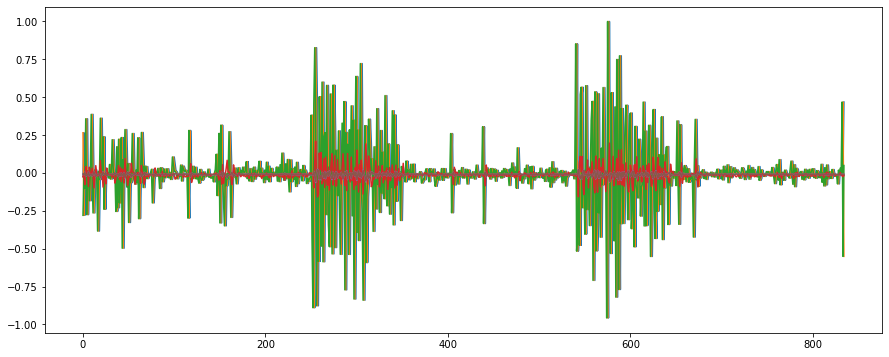

In [134]:
plt.plot(y_val)
plt.plot(y_val_hat)

In [135]:
y_val_hat = scaler.inverse_transform(np.asarray(y_val_hat).reshape(-1, 1))
y_val = scaler.inverse_transform(np.asarray(y_val[:, 0]).reshape(-1, 1))

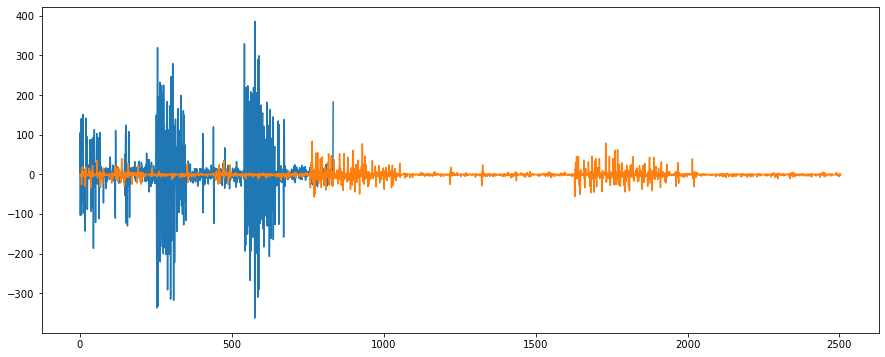

In [136]:
plt.plot(y_val)
plt.plot(y_val_hat)

In [137]:
val_starting_idx = 1+288+2+split_idx # 1 = detrend, 288 = deseasonalize, 2=input seq created nans
for i in range(len(y_val_hat)):
    extra = dt_data['load'].values[val_starting_idx + i - 288] + data['load'].values[val_starting_idx + i - 1]
#     y_val_hat[i] += extra
#     y_val[i] += extra
    print(y_val_hat[i], y_val[i], extra)

[-5.88071] [-6.58] 3407.03
[0.49338946] [104.78] 3480.6499999999996
[0.49926424] [-103.57] 3379.1600000000003
[-1.093757] [-1.66] 3357.5
[-0.64623034] [-36.16] 3303.6
[-0.5308634] [140.05] 3438.91
[-25.983215] [-101.89] 3317.1800000000003
[5.27915] [8.46] 3323.39
[4.8252187] [4.35] 3304.8700000000003
[19.113321] [-66.81] 3230.43
[-5.4568872] [1.81] 3228.7200000000003
[-4.8793216] [151.18] 3358.0699999999997
[3.1032388] [-2.53] 3344.5099999999998
[-1.6454003] [-97.6] 3236.8300000000004
[-1.4340352] [1.07] 3230.0499999999997
[8.126014] [11.25] 3217.9900000000002
[-2.8411617] [-3.94] 3214.4799999999996
[-2.5149102] [-3.76] 3196.52
[-30.742435] [-143.31] 3042.94
[6.412167] [7.29] 3051.19
[5.8493776] [-13.17] 3019.94
[17.710094] [141.52] 3161.98
[-5.122823] [-6.72] 3146.1200000000003
[-4.577355] [-1.19] 3141.21
[0.33531192] [94.58] 3232.6299999999997
[-0.9864459] [-88.29] 3134.46
[-0.8383915] [-6.44] 3125.0099999999998
[-2.7051406] [-3.8] 3112.4
[-0.2626116] [1.62] 3119.07
[-0.184102] [3.08

[0.69242597] [4.15] 2944.0899999999997
[-1.0714632] [-8.5] 2995.92
[-0.9152405] [15.31] 2982.86
[0.43962038] [-0.98] 3012.2999999999997
[-1.0112786] [2.24] 3014.1400000000003
[-0.86083835] [-10.24] 3045.53
[-5.452434] [-1.52] 3020.35
[0.39143088] [-17.91] 3036.2699999999995
[0.40710163] [10.01] 3057.94
[-2.8075418] [12.57] 3081.36
[-0.23823301] [-3.27] 3078.89
[-0.16206552] [-18.47] 3102.67
[3.9938066] [16.42] 3130.6800000000003
[-1.8574159] [-32.57] 3099.91
[-1.6256806] [-18.56] 3148.71
[-1.758851] [31.7] 3156.2200000000003
[-0.487893] [-20.93] 3202.24
[-0.38773838] [14.6] 3202.8500000000004
[-6.0874844] [-14.37] 3244.91
[0.54261565] [15.03] 3280.85
[0.5437609] [-9.19] 3286.7000000000003
[-2.1746914] [-6.41] 3329.61
[-0.38889465] [-6.09] 3343.1500000000005
[-0.2982518] [7.23] 3371.99
[-1.9717199] [-1.92] 3399.4500000000003
[-0.43721548] [9.4] 3464.7
[-0.3419301] [-21.35] 3434.4500000000003
[-4.4549375] [4.83] 3495.07
[0.15395866] [-17.] 3523.79
[0.19244526] [7.59] 3531.5499999999997
[

IndexError: index 835 is out of bounds for axis 0 with size 835

## so, the difference values are so large in comparision to the predictions that it makes miniscule change in the y_val, and y_val_hat plots

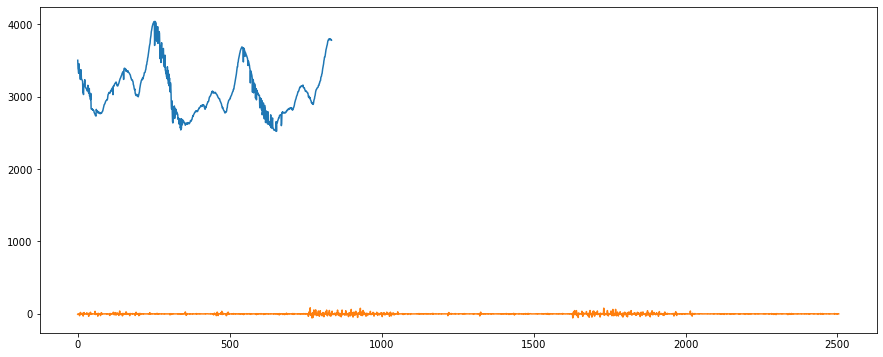

In [138]:
plt.plot(data['load'].values[1+288+2+split_idx:])
plt.plot(y_val_hat)

In [139]:
np.array([1]).shape

(1,)

Forecasting with the predicted values instead of val set values:

In [140]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    X = test[0, 0:n_lag]
    for i in range(len(test)):        
        X = X.reshape(1, 1, len(X))
        # make forecast
        forecast = model.predict(X, batch_size=n_batch)[0, 0]
        X = np.array([forecast])
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# Version 2

Use last `nlags` days values at time t to predict the load of today's time t load

In [141]:
data.head(3)

,load
datetime,
2021-04-14 00:00:00,3611.79
2021-04-14 00:05:00,3574.68
2021-04-14 00:10:00,3563.17


<AxesSubplot:xlabel='datetime'>

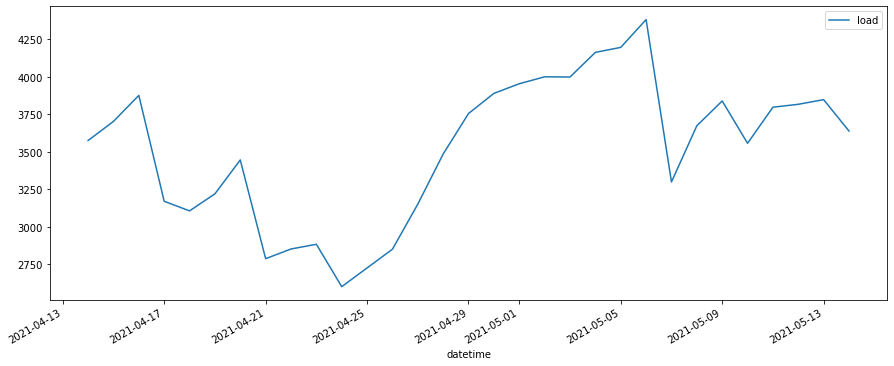

In [142]:
data.at_time('00:05:00').plot()

In [143]:
df = pd.DataFrame(columns=['time'] + list(map(str, range(30))))

In [144]:
for idx, time in enumerate(sorted(set(data.index.time))):
    df.loc[idx] = [time.strftime(format='%H:%M:%S')] + list(data.at_time(time)['load'].values)
#     data.at_time(time).plot()
#     if idx>10: break

In [145]:
df.head()

,time,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,00:00:00,3611.79,3760.63,3898.24,3182.17,3115.15,3227.85,3480.34,2790.63,2879.93,...,4235.98,4419.45,3285.38,3673.21,3860.49,3563.57,3811.70,3862.22,3854.23,3649.37
1,00:05:00,3574.68,3702.24,3875.95,3169.13,3105.00,3218.79,3444.93,2786.00,2850.60,...,4196.33,4381.74,3298.06,3673.01,3838.81,3556.13,3796.90,3816.44,3847.48,3637.83
2,00:10:00,3563.17,3701.74,3841.55,3153.04,3089.36,3207.49,3433.56,2778.25,2850.14,...,4186.90,4377.74,3305.03,3648.57,3837.10,3556.28,3783.50,3906.30,3756.04,3554.18
3,00:15:00,3537.44,3673.48,3835.90,3149.69,3077.09,3179.09,3419.06,2770.05,2827.86,...,4170.87,4357.05,3293.27,3653.74,3822.32,3537.53,3769.10,3882.50,3964.77,3611.85
4,00:20:00,3529.50,3659.89,3805.91,3127.15,3066.86,3173.47,3403.72,2750.60,2818.63,...,4167.29,4334.57,3278.81,3634.22,3807.73,3529.84,3747.38,3872.71,3734.13,3604.75


In [146]:
df.index = df['time']
df = df.drop('time', 1)

In [147]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,3611.79,3760.63,3898.24,3182.17,3115.15,3227.85,3480.34,2790.63,2879.93,2907.37,...,4235.98,4419.45,3285.38,3673.21,3860.49,3563.57,3811.70,3862.22,3854.23,3649.37
00:05:00,3574.68,3702.24,3875.95,3169.13,3105.00,3218.79,3444.93,2786.00,2850.60,2881.99,...,4196.33,4381.74,3298.06,3673.01,3838.81,3556.13,3796.90,3816.44,3847.48,3637.83
00:10:00,3563.17,3701.74,3841.55,3153.04,3089.36,3207.49,3433.56,2778.25,2850.14,2880.24,...,4186.90,4377.74,3305.03,3648.57,3837.10,3556.28,3783.50,3906.30,3756.04,3554.18
00:15:00,3537.44,3673.48,3835.90,3149.69,3077.09,3179.09,3419.06,2770.05,2827.86,2871.98,...,4170.87,4357.05,3293.27,3653.74,3822.32,3537.53,3769.10,3882.50,3964.77,3611.85
00:20:00,3529.50,3659.89,3805.91,3127.15,3066.86,3173.47,3403.72,2750.60,2818.63,2854.44,...,4167.29,4334.57,3278.81,3634.22,3807.73,3529.84,3747.38,3872.71,3734.13,3604.75


In [148]:
df.loc['00:00:00']

0     3611.79
1     3760.63
2     3898.24
3     3182.17
4     3115.15
5     3227.85
6     3480.34
7     2790.63
8     2879.93
9     2907.37
10    2610.93
11    2857.19
12    3176.31
13    3509.05
14    3770.72
15    3911.01
16    3950.13
17    4021.98
18    4002.98
19    4174.84
20    4235.98
21    4419.45
22    3285.38
23    3673.21
24    3860.49
25    3563.57
26    3811.70
27    3862.22
28    3854.23
29    3649.37
Name: 00:00:00, dtype: float64

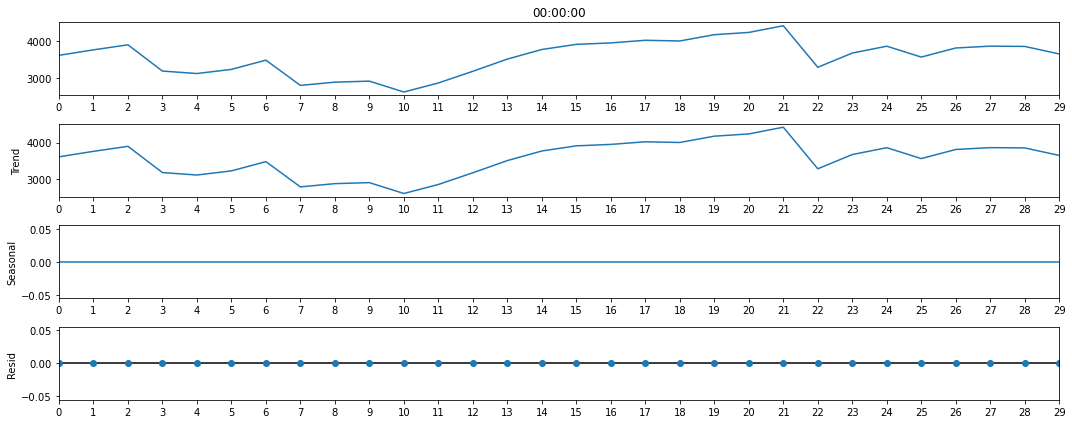

In [150]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 1 #daily freq

result = seasonal_decompose(df.loc['00:00:00'], period=decompfreq, model='aditive')

result.plot()
plt.show()

Only trend is present not seasonality

In [151]:
dt_df = df.diff(1, axis=1)

In [152]:
dt_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,NaN,148.84,137.61,-716.07,-67.02,112.70,252.49,-689.71,89.30,27.44,...,61.14,183.47,-1134.07,387.83,187.28,-296.92,248.13,50.52,-7.99,-204.86
00:05:00,NaN,127.56,173.71,-706.82,-64.13,113.79,226.14,-658.93,64.60,31.39,...,33.42,185.41,-1083.68,374.95,165.80,-282.68,240.77,19.54,31.04,-209.65
00:10:00,NaN,138.57,139.81,-688.51,-63.68,118.13,226.07,-655.31,71.89,30.10,...,35.75,190.84,-1072.71,343.54,188.53,-280.82,227.22,122.80,-150.26,-201.86
00:15:00,NaN,136.04,162.42,-686.21,-72.60,102.00,239.97,-649.01,57.81,44.12,...,31.16,186.18,-1063.78,360.47,168.58,-284.79,231.57,113.40,82.27,-352.92
00:20:00,NaN,130.39,146.02,-678.76,-60.29,106.61,230.25,-653.12,68.03,35.81,...,43.43,167.28,-1055.76,355.41,173.51,-277.89,217.54,125.33,-138.58,-129.38


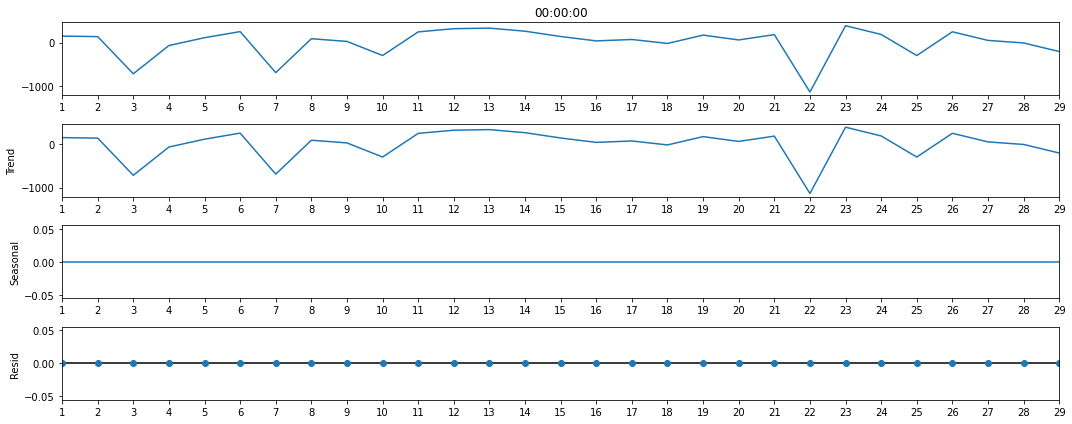

In [154]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 1 #daily freq

result = seasonal_decompose(dt_df.loc['00:00:00'].dropna(), period=decompfreq, model='aditive')

result.plot()
plt.show()

In [155]:
dt_df = dt_df.dropna(axis=1)

In [156]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(dt_df.values.reshape(-1, 1))

In [157]:
dt_df = scaler.transform(dt_df)  # df is now a numpy array

In [158]:
split_idx = int(len(dt_df) * 0.8)
train, val = dt_df[:split_idx, :], dt_df[split_idx:, :]

In [159]:
train.shape, val.shape

((230, 29), (58, 29))

In [160]:
def prepare_data(data, nlags):
    '''prepares data for LSTM model, x=last nlags values, y=(nlags+1)'th value'''
    data_x, data_y = [], []
    for i in range(data.shape[0]):
        for j in range(0, data.shape[1]-nlags):
            data_x.append(data[i, j:j+nlags])
            data_y.append(data[i, j+nlags])
    data_x = np.array(data_x)
    data_y = np.array(data_y).reshape(-1, 1)
    return data_x, data_y

In [161]:
nlags = 20 
train_x, train_y = prepare_data(train, nlags)
val_x, val_y = prepare_data(val, nlags)

In [162]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2070, 20), (2070, 1), (522, 20), (522, 1))

## Model training

In [163]:
train_x = train_x.reshape(train_x.shape[0], 1, nlags)
val_x = val_x.reshape(val_x.shape[0], 1, nlags)

In [164]:
model = Sequential()
model.add(LSTM(1, batch_input_shape=(1, train_x.shape[1], train_x.shape[2]), stateful=True))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [165]:
# fit network
for i in range(10):
    model.fit(train_x, train_y, epochs=1, batch_size=1, verbose=1, validation_data=(val_x, val_y), shuffle=False)
    model.reset_states()

2070/2070 [==============================] - 9s 3ms/step - loss: 0.0018 - val_loss: 0.0086


In [166]:
val_y_pred = model.predict(val_x, batch_size=1)

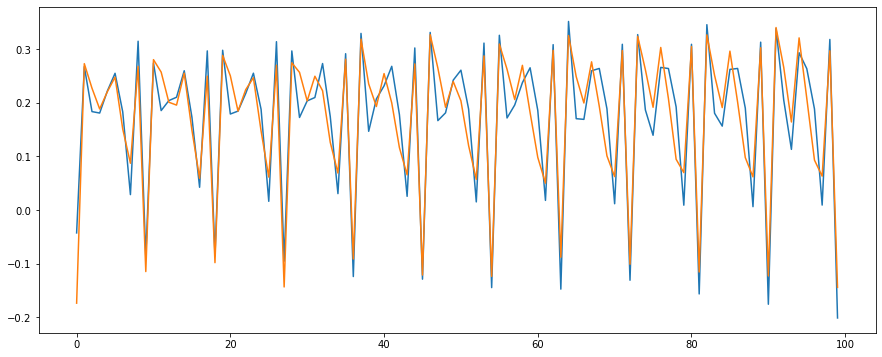

In [167]:
plt.plot(val_y[:100])
plt.plot(val_y_pred[:100])

In [168]:
inverted_val_y = scaler.inverse_transform(val_y)
inverted_val_y_pred = scaler.inverse_transform(val_y_pred)

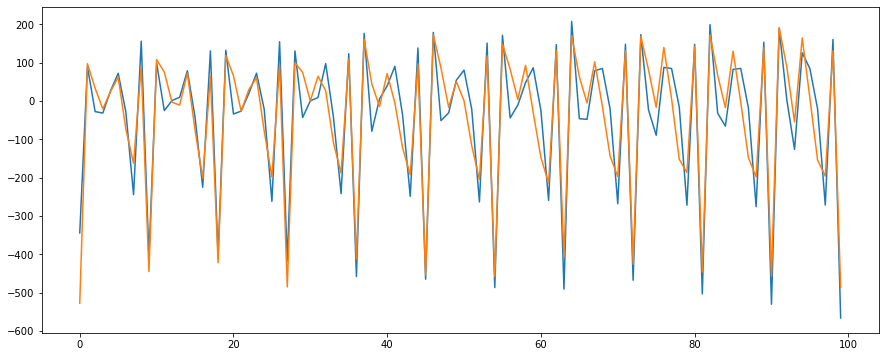

In [169]:
plt.plot(inverted_val_y[:100])
plt.plot(inverted_val_y_pred[:100])

the whole process of inverting to orignal scale is same for val_y and val_y_pred (value addition only), so values are going to be close if they are now


In [170]:
data.tail() 

,load
datetime,
2021-05-14 23:35:00,3797.48
2021-05-14 23:40:00,3794.17
2021-05-14 23:45:00,3789.13
2021-05-14 23:50:00,3775.20
2021-05-14 23:55:00,3778.78


let's predict yesterday's load which is not present in monthdata.csv file as of now

we need 288, 1, 20 matrix with last 20 days load for each 288 time stamp


In [171]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,3611.79,3760.63,3898.24,3182.17,3115.15,3227.85,3480.34,2790.63,2879.93,2907.37,...,4235.98,4419.45,3285.38,3673.21,3860.49,3563.57,3811.70,3862.22,3854.23,3649.37
00:05:00,3574.68,3702.24,3875.95,3169.13,3105.00,3218.79,3444.93,2786.00,2850.60,2881.99,...,4196.33,4381.74,3298.06,3673.01,3838.81,3556.13,3796.90,3816.44,3847.48,3637.83
00:10:00,3563.17,3701.74,3841.55,3153.04,3089.36,3207.49,3433.56,2778.25,2850.14,2880.24,...,4186.90,4377.74,3305.03,3648.57,3837.10,3556.28,3783.50,3906.30,3756.04,3554.18
00:15:00,3537.44,3673.48,3835.90,3149.69,3077.09,3179.09,3419.06,2770.05,2827.86,2871.98,...,4170.87,4357.05,3293.27,3653.74,3822.32,3537.53,3769.10,3882.50,3964.77,3611.85
00:20:00,3529.50,3659.89,3805.91,3127.15,3066.86,3173.47,3403.72,2750.60,2818.63,2854.44,...,4167.29,4334.57,3278.81,3634.22,3807.73,3529.84,3747.38,3872.71,3734.13,3604.75


In [172]:
df_last_21 = df.loc[:, '9':]

In [173]:
df_last_21.head()

,9,10,11,12,13,14,15,16,17,18,...,20,21,22,23,24,25,26,27,28,29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,2907.37,2610.93,2857.19,3176.31,3509.05,3770.72,3911.01,3950.13,4021.98,4002.98,...,4235.98,4419.45,3285.38,3673.21,3860.49,3563.57,3811.70,3862.22,3854.23,3649.37
00:05:00,2881.99,2599.17,2849.26,3150.43,3484.85,3755.16,3889.35,3953.64,3999.86,3998.60,...,4196.33,4381.74,3298.06,3673.01,3838.81,3556.13,3796.90,3816.44,3847.48,3637.83
00:10:00,2880.24,2595.94,2846.09,3139.99,3484.09,3742.44,3869.15,3929.21,4001.21,3980.15,...,4186.90,4377.74,3305.03,3648.57,3837.10,3556.28,3783.50,3906.30,3756.04,3554.18
00:15:00,2871.98,2573.75,2818.21,3132.49,3455.22,3730.83,3849.10,3936.41,3997.29,3984.11,...,4170.87,4357.05,3293.27,3653.74,3822.32,3537.53,3769.10,3882.50,3964.77,3611.85
00:20:00,2854.44,2579.57,2827.26,3111.43,3452.67,3713.79,3825.90,3911.33,3971.95,3948.08,...,4167.29,4334.57,3278.81,3634.22,3807.73,3529.84,3747.38,3872.71,3734.13,3604.75


In [174]:
dt_df_last_20 = df_last_21.diff(1, axis=1).dropna(axis=1)  #taking last 21 days, differencing and dropping the nan value

In [175]:
dt_df_last_20.head()

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
time,,,,,,,,,,,,,,,,,,,,
00:00:00,-296.44,246.26,319.12,332.74,261.67,140.29,39.12,71.85,-19.00,171.86,61.14,183.47,-1134.07,387.83,187.28,-296.92,248.13,50.52,-7.99,-204.86
00:05:00,-282.82,250.09,301.17,334.42,270.31,134.19,64.29,46.22,-1.26,164.31,33.42,185.41,-1083.68,374.95,165.80,-282.68,240.77,19.54,31.04,-209.65
00:10:00,-284.30,250.15,293.90,344.10,258.35,126.71,60.06,72.00,-21.06,171.00,35.75,190.84,-1072.71,343.54,188.53,-280.82,227.22,122.80,-150.26,-201.86
00:15:00,-298.23,244.46,314.28,322.73,275.61,118.27,87.31,60.88,-13.18,155.60,31.16,186.18,-1063.78,360.47,168.58,-284.79,231.57,113.40,82.27,-352.92
00:20:00,-274.87,247.69,284.17,341.24,261.12,112.11,85.43,60.62,-23.87,175.78,43.43,167.28,-1055.76,355.41,173.51,-277.89,217.54,125.33,-138.58,-129.38


In [176]:
dt_df_last_20 = scaler.transform(dt_df_last_20)  # df is now a numpy array

In [177]:
X = dt_df_last_20.reshape(dt_df_last_20.shape[0], 1, nlags)  # nlags=20

In [178]:
Y = model.predict(X, batch_size=1)  # predict for today's values

In [179]:
inv_Y = scaler.inverse_transform(Y)  # invert to detrended values' scale

In [180]:
inv_Y.shape

(288, 1)

In [187]:
rescaled_Y = [x+y for x, y in zip(inv_Y[:, 0], df.iloc[:, -1])]  # last day's values added to inv_Y to get it to original scale

In [190]:
## get today's load

def get_load_data(date):
    load=[]
    url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
    print('Scraping ' + date, end=' ')
    resp = requests.get(url + date) # send a get request to the url, get response
    soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
    table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
    trs = table.findAll('tr') # extract all rows of the table
    if len(trs[1:])==288: # no need to create csv file, if there's no data
        with open('lstmdata.csv', 'a') as f:  #'a' makes sure the values are appended at the end of the already existing file
            
            for tr in trs[1:]:
                time, delhi = tr.findChildren('font')[:2]
                load.append(delhi.text)
    if len(trs[1:]) != 288:
        print('Some of the load values are missing..')
    else:
        print('Done')
    return load

yesterday = datetime.today() - timedelta(1)
yesterday = yesterday.strftime('%d/%m/%Y')
load = get_load_data(yesterday)

Scraping 14/05/2021 Done


In [191]:
load = [float(x) for x in load]

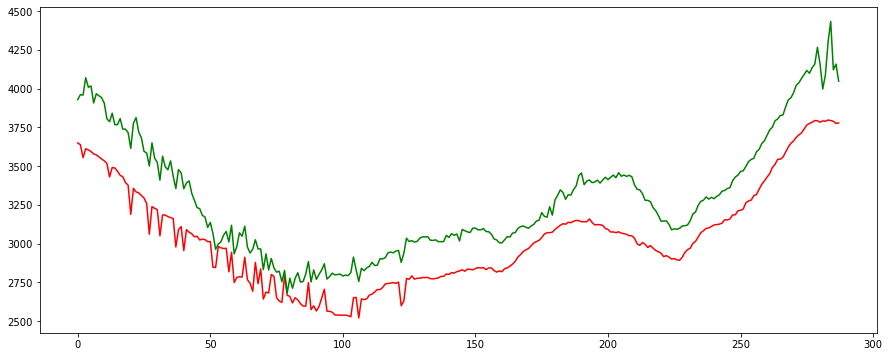

In [201]:
plt.plot(load, label= "actual load", color="red")
plt.plot(rescaled_Y, label= "predicted load", color="green")